# **UW-Madison GI Tract Image Segmentation**
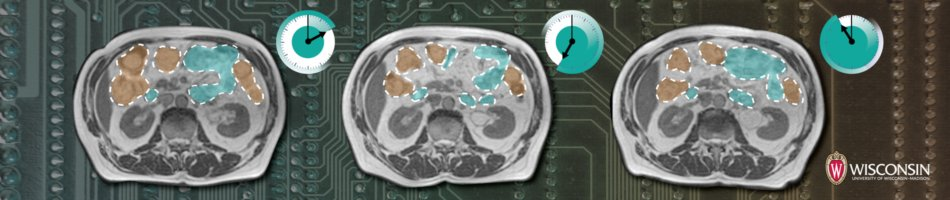


# **What is needed?**

In 2019, an estimated 5 million people were diagnosed with a cancer of the gastro-intestinal tract worldwide. Of these patients, about half are eligible for radiation therapy, usually delivered over 10-15 minutes a day for 1-6 weeks. Radiation oncologists try to deliver high doses of radiation using X-ray beams pointed to tumors while avoiding the stomach and intestines. With newer technology such as integrated magnetic resonance imaging and linear accelerator systems, also known as MR-Linacs, oncologists are able to visualize the daily position of the tumor and intestines, which can vary day to day. In these scans, radiation oncologists must manually outline the position of the stomach and intestines in order to adjust the direction of the x-ray beams to increase the dose delivery to the tumor and avoid the stomach and intestines. This is a time-consuming and labor intensive process that can prolong treatments from 15 minutes a day to an hour a day, which can be difficult for patients to tolerate—unless deep learning could help automate the segmentation process. A method to segment the stomach and intestines would make treatments much faster and would allow more patients to get more effective treatment.

In this competition, you’ll create a model to automatically segment the stomach and intestines on MRI scans. The MRI scans are from actual cancer patients who had 1-5 MRI scans on separate days during their radiation treatment. You'll base your algorithm on a dataset of these scans to come up with creative deep learning solutions that will help cancer patients get better care.

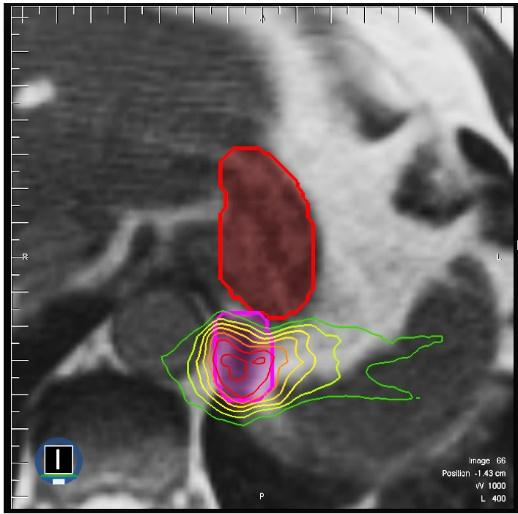!
Description Image
In this figure, the tumor (pink thick line) is close to the stomach (red thick line). High doses of radiation are directed to the tumor while avoiding the stomach. The dose levels are represented by the rainbow of outlines, with higher doses represented by red and lower doses represented by green. 


# Approch 

Refer: [https://www.kaggle.com/sumitjha19/uwmg-e2e-train-pipeline-efficientnet-unet-pytorch](http://)

> **Training Summary**
> * Divide whole training data into 3 groups : data with all 3 classes, 2 classes, 1 class
> * Divide Train:Valid dataset with 75,80,85 : 25,20,15 ratio - across 3 classes
> * Train Efficent-Unet model with patch size: 265x256 , 3 channel outputs- 1 for each class
> * Used Sigmod Activation for outputs
> * DICE loss used
> * Used pytorch SMP package 


> # If you like the notebook then please UPVOTE

In [ ]:
import os
import pandas as pd
import cv2
from PIL import Image
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import Video,display
from IPython.display import HTML
from base64 import b64encode
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
import seaborn as sns
import numpy as np
import pandas as pd
import glob
import time
from sklearn.model_selection import train_test_split
import albumentations as A
from torchvision.transforms import ToTensor, Lambda
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.augmentations.transforms import RandomGamma
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
import cv2
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torchvision.transforms import ToTensor
from torch.optim import SGD,Adam,RMSprop
from torch import nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from IPython.display import FileLink 

In [ ]:
!cp -r ../input/smppackage ./localpkg

In [ ]:
!pip install -q ./localpkg/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
!pip install -q ./localpkg/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
!pip install -q ./localpkg/timm-0.4.12-py3-none-any.whl
!pip install -q ./localpkg/segmentation_models_pytorch-0.2.1-py3-none-any.whl

In [ ]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn


In [ ]:
ROOT_PATH = r'../input/uw-madison-gi-tract-image-segmentation'
TRAIN_PATH = os.path.join(ROOT_PATH,'train')
TRAIN_CSV = os.path.join(ROOT_PATH,'train.csv')
OUTPUT_PATH = r'/kaggle/working/'
TRAIN_UPDATE_CSV = os.path.join(OUTPUT_PATH,'train_updated.csv')
SAVE_MASK = os.path.join(OUTPUT_PATH,'mask')
os.makedirs(SAVE_MASK,exist_ok=True)
CLASS_MAPPING = {'large_bowel':128,'small_bowel':200,'stomach':255}
CLASS_REVERSE_MAPPING = {128:'large_bowel',200:'small_bowel',255:'stomach'}
CLASS_CHANNEL_MAPPING = {'large_bowel':0,'small_bowel':1,'stomach':2}
MODEL_SIZE = 256
model_weight_path = r'../input/effunetweight/model_weight_epoch_best2.pth'
#model_weight_path = r'../input/effunetweight/model_weight_epoch_best3_on_best2_val_dice_loss_0p929.pth'
model_weight_path = r'../input/effunetweight/model_weight_epoch_best_cy3.pth'#../input/effunetweight/model_weight_epoch_best_cycle2.pth' #../input/effunetweight/model_weight_epoch_best_train_moreaug_25eph.pth'

In [ ]:
# functions to convert encoding to mask and mask to encoding
def rle2mask(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


def mask2enc(mask, n=1):
    pixels = mask.T.flatten()
    encs = []
    for i in range(1, n + 1):
        p = (pixels == i).astype(np.int8)
        if p.sum() == 0:
            encs.append(np.nan)
        else:
            p = np.concatenate([[0], p, [0]])
            runs = np.where(p[1:] != p[:-1])[0] + 1
            runs[1::2] -= runs[::2]
            encs.append(' '.join(str(x) for x in runs))
    return encs


# https://www.kaggle.com/bguberfain/memory-aware-rle-encoding
# with transposed mask
def rle_encode_less_memory(img):
    # the image should be transposed
    pixels = img.T.flatten()

    # This simplified method requires first and last pixel to be zero
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] -= runs[::2]

    return ' '.join(str(x) for x in runs)

In [ ]:
def read_image_unit16(path,normalize=True):
    img = cv2.imread(path,-1)
    if normalize:
        img = np.uint8(255 * ((img - img.min()) / (img.max() - img.min())))
    else:
        img = np.uint8(255*img/65535)

    return img

In [ ]:
valid_transform = A.Compose([
    A.Resize(width=MODEL_SIZE, height=MODEL_SIZE,p=1),
    ToTensorV2(p=1)
])

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
def get_model(pre_train_model_state_dict_path=None):
    if MODEL_SIZE == 512:
        dec_chn = (256, 128, 64, 32, 16)
    elif MODEL_SIZE == 256:
        dec_chn = (128, 64, 32, 16, 8)
    else:
        raise NotImplementedError
    print('dec chn-',dec_chn)
    model = smp.Unet(encoder_name="efficientnet-b4",
                     encoder_depth = 5,
                     encoder_weights= None,
                     decoder_use_batchnorm=True,
                     decoder_channels = dec_chn,
                     decoder_attention_type = None, #scse- https://blog.paperspace.com/scse-nets/
                     in_channels = 1,
                     classes = 3,
                     activation = None,#'sigmoid', #sigmoid"/"softmax
                     aux_params = None)
    if pre_train_model_state_dict_path is not None:
        model.load_state_dict(torch.load(pre_train_model_state_dict_path,
                                              map_location=device))
        print('loaded with given weight!!')
    model.to(device)
    #summary(model, (1, MODEL_SIZE, MODEL_SIZE))
    print('Model loaded successfully')
    return model

In [ ]:
model = get_model(pre_train_model_state_dict_path=model_weight_path)

In [ ]:
class UWMInferenceDataset(Dataset):
    def __init__(self,test_df,
                 transform,
                 ref_image_size=(256,256),
                 ref_pix_size=(1.5,1.5)):

        self.test_df = test_df
        self.ref_image_size = ref_image_size
        self.ref_pix_size = ref_pix_size
        self._transform = transform

    def __len__(self):
        return self.test_df.shape[0]

    def __getitem__(self, idx):
        item = self.test_df.iloc[idx,:]
        imgpath = item['imagepath']
        imgH, imgW =  item['H'],item['W']
        pixH, pixW =  item['PIXH'],item['PIXW']
        image_id = item['id']
        
        image = read_image_unit16(imgpath,normalize=True)
        if self._transform is not None:
            transformed = self._transform(image=image)
            transformed_image = transformed['image']
        else:
            transformed_image = image
        transformed_image = transformed_image / 255.0
        
        return  transformed_image,imgH,imgW,pixH,pixW,image_id

In [ ]:
def fx_train(x):
    p = x.split('_')
    caseid = p[0]
    day = p[1]
    idx = p[3]
    file_id = f'slice_{idx}'
    path = os.path.join(ROOT_PATH,'train',f'{caseid}',f'{caseid}_{day}','scans')
    files = glob.glob(os.path.join(path,f'{file_id}*.png'))
    if len(files)==1:
        return files[0]
    else:
        print('more than one file',files)
        return files[0]
    
def fx_test(x):
    p = x.split('_')
    caseid = p[0]
    day = p[1]
    idx = p[3]
    file_id = f'slice_{idx}'
    path = os.path.join(ROOT_PATH,'test',f'{caseid}',f'{caseid}_{day}','scans')
    files = glob.glob(os.path.join(path,f'{file_id}*.png'))
    if len(files)==1:
        return files[0]
    else:
        print('more than one file',files)
        return files[0]

In [ ]:
def extract_metadata(df,mode='test'):
    df['caseid'] = df['id'].map(lambda x : x.split('_')[0])
    df['days'] = df['id'].map(lambda x : x.split('_')[1])
    df['slice_id'] = df['id'].map(lambda x : x.split('_')[3])
    if mode == 'test':
        df['imagepath'] = df['id'].map(fx_test)
    else:
        df['imagepath'] = df['id'].map(fx_train)
    #get_image stats:
    df['img_name'] = df['imagepath'].map(lambda x: os.path.basename(x))
    df['H'] = df['img_name'].map(lambda x: int(x.split('_')[2]))
    df['W'] = df['img_name'].map(lambda x: int(x.split('_')[3]))
    df['PIXH'] = df['img_name'].map(lambda x: float(x.split('_')[4]))
    df['PIXW'] = df['img_name'].map(lambda x: float(x.split('_')[5][:-4]))
    
    return df

In [ ]:
INPUT_ROOT = r'../input/uw-madison-gi-tract-image-segmentation'
TEST_ROOT = r'../input/uw-madison-gi-tract-image-segmentation/test'
sam_df = pd.read_csv(os.path.join(INPUT_ROOT,'sample_submission.csv'))
sam_df.head()

In [ ]:
is_test_empty = len(sam_df) > 0
if not is_test_empty:
    test_df = pd.read_csv(os.path.join(INPUT_ROOT,"train.csv"))
    test_df = test_df[:1000*3] # only 1000 cases
    test_df = test_df.drop(columns=["class", "segmentation"]).drop_duplicates()
    test_df = extract_metadata(test_df,mode='train')
else:
    test_df = sam_df.drop(columns=["class", "predicted"]).drop_duplicates()
    test_df = extract_metadata(test_df,mode='test')
    
    
print(test_df.head())
print(test_df['imagepath'][0])

In [ ]:
def update_get_rle_mask_info(pred,img_id,Ht,Wt,thd=0.5):
    B,hp,wp,c = pred.shape
    #print(B,hp,wp,img_id,Ht,Wt)
    for bidx in range(B):
        _prm = pred[bidx,...] > thd
        for i in range(3):
            _mask = _prm[:,:,i]
            _cls = REVERSE_CLASS_CHANNEL_MAPPING[i]
            imgList.append(img_id[bidx])
            classList.append(_cls)
            if np.sum(_mask) > 0:
                _wt,_ht = int(Ht[bidx]),int(Wt[bidx])
                _m_rsz= cv2.resize(np.uint8(_mask.T),(_ht,_wt),interpolation=cv2.INTER_AREA)
                rle = rle_encode_less_memory(_m_rsz)
                rleList.append(rle)
            else:
                rleList.append(' ') 

In [ ]:
imgList,classList,rleList = [],[],[]
CLASS_CHANNEL_MAPPING = {'large_bowel':0,'small_bowel':1,'stomach':2}
REVERSE_CLASS_CHANNEL_MAPPING = {0:'large_bowel',1:'small_bowel',2:'stomach'}

batch_size = 2
DEBUG = False
threshold = 0.5
test_ds = UWMInferenceDataset(test_df=test_df,
                     transform=valid_transform)

test_dl = DataLoader(test_ds, batch_size= batch_size,
                     drop_last=False,              
                     shuffle=False,num_workers=1,pin_memory=True)

model.eval()
pbar = tqdm(test_dl)
count = 0
with torch.no_grad():
    for i, data in enumerate(pbar):
        image,H,W,pH,pW,image_id = data
        image = image.to(device,dtype=torch.float)
        out = model(image)
        out = F.logsigmoid(out).exp()
        out = out.permute([0,2,3,1])
        out = out.squeeze()
        #out = (out > 0.25).int()
        out = out.detach().cpu().numpy().squeeze()
        pred = 255*np.uint8(out > threshold)
        update_get_rle_mask_info(pred,image_id,H.numpy(),W.numpy(),threshold)
        if DEBUG:
            print(pred.shape,pred.dtype,pred[:,:,:,0].max(),pred[:,:,:,1].max(),pred[:,:,:,2].max())
            print(pred.shape)
            #cv2.imwrite('./test.png',pred[0,...])
            out = np.uint8(pred)
            img = image.permute([0,2,3,1])
            img = img.numpy().squeeze()
            plt.subplot(batch_size,2,1)
            for k in range(batch_size):
                plt.subplot(k+1,2,1)
                plt.imshow(img[k,...]) 
                plt.subplot(k+1,2,2)
                plt.imshow(out[k,...])  
                plt.show()
            if count > 25:
                break

            count +=1
   

In [ ]:
if DEBUG:
    _m = rle2mask(rleList[2],(266,266))
    plt.imshow(_m)
    test_df.iloc[239,:]

In [ ]:
res = {'id':imgList,'class':classList,'predicted':rleList}
sub_df = pd.DataFrame(res,columns=['id','class','predicted'])

In [ ]:
sub_df.to_csv("submission.csv", index=False)


In [ ]:
sub_df.head()